In [257]:
import os
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
from tqdm import tqdm
import glob
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import re
import gc
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob

In [258]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses, callbacks
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import FileLink, display

In [259]:
sns.set(style='whitegrid')

In [260]:
#load datasets
train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bbox = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
test_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")


# print dataframe shapes
print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('test shape:', test_df.shape)
print('')


train shape: (2019, 9)
train bbox shape: (7217, 6)
test shape: (3, 3)



In [261]:
train_df.head()

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0
3  1.2.826.0.1.3680043.12351                0   0   0   0   0   0   0   0
4   1.2.826.0.1.3680043.1363                1   0   0   0   0   1   0   0

In [262]:
train_bbox.head(20)

StudyInstanceUID          x          y     width    height  \
0   1.2.826.0.1.3680043.10051  219.27715  216.71419  17.30440  20.38517   
1   1.2.826.0.1.3680043.10051  221.56460  216.71419  17.87844  25.24362   
2   1.2.826.0.1.3680043.10051  216.82151  221.62546  27.00959  26.37454   
3   1.2.826.0.1.3680043.10051  214.49455  215.48637  27.92726  37.51363   
4   1.2.826.0.1.3680043.10051  214.00000  215.48637  27.00000  43.51363   
5   1.2.826.0.1.3680043.10051  213.56364  216.71419  25.13455  47.92717   
6   1.2.826.0.1.3680043.10051  209.00000  214.57591  36.06131  51.56834   
7   1.2.826.0.1.3680043.10051  204.25455  212.24727  47.47636  57.71635   
8   1.2.826.0.1.3680043.10051  205.00000  213.87342  45.00000  59.12658   
9   1.2.826.0.1.3680043.10051  205.18545  214.76814  42.89892  63.43364   
10  1.2.826.0.1.3680043.10051  203.00000  217.00000  42.00000  62.07843   
11  1.2.826.0.1.3680043.10051  201.00000  219.00000  41.00000  58.00000   
12  1.2.826.0.1.3680043.10051  199.60000  220.62545  40.02908  56.78546   
13  1.2.826.0.1.3680043.10051  195.00000  221.00000  51.00000  58.00000   
14  1.2.826.0.1.3680043.10051  191.22182  221.43460  61.44000  60.63086   
15  1.2.826.0.1.3680043.10051  200.16292  232.42136  23.32854  31.92325   
16  1.2.826.0.1.3680043.10579  250.18182  244.96552  35.52992  33.79122   
17  1.2.826.0.1.3680043.10579  247.14625  245.00000  39.94924  35.28457   
18  1.2.826.0.1.3680043.10579  249.96552  244.96552  34.42758  42.55520   
19  1.2.826.0.1.3680043.10678  231.00000  227.00000  50.00000  36.00000   

    slice_number  
0            133  
1            134  
2            135  
3            136  
4            137  
5            138  
6            139  
7            140  
8            141  
9            142  
10           143  
11           144  
12           145  
13           146  
14           147  
15           148  
16            78  
17            79  
18            80  
19           118

In [263]:
test_df.head()

row_id           StudyInstanceUID prediction_type
0  1.2.826.0.1.3680043.10197_C1  1.2.826.0.1.3680043.10197              C1
1  1.2.826.0.1.3680043.10454_C1  1.2.826.0.1.3680043.10454              C1
2  1.2.826.0.1.3680043.10690_C1  1.2.826.0.1.3680043.10690              C1

Text(0.5, 1.0, 'Fractures by vertebrae')

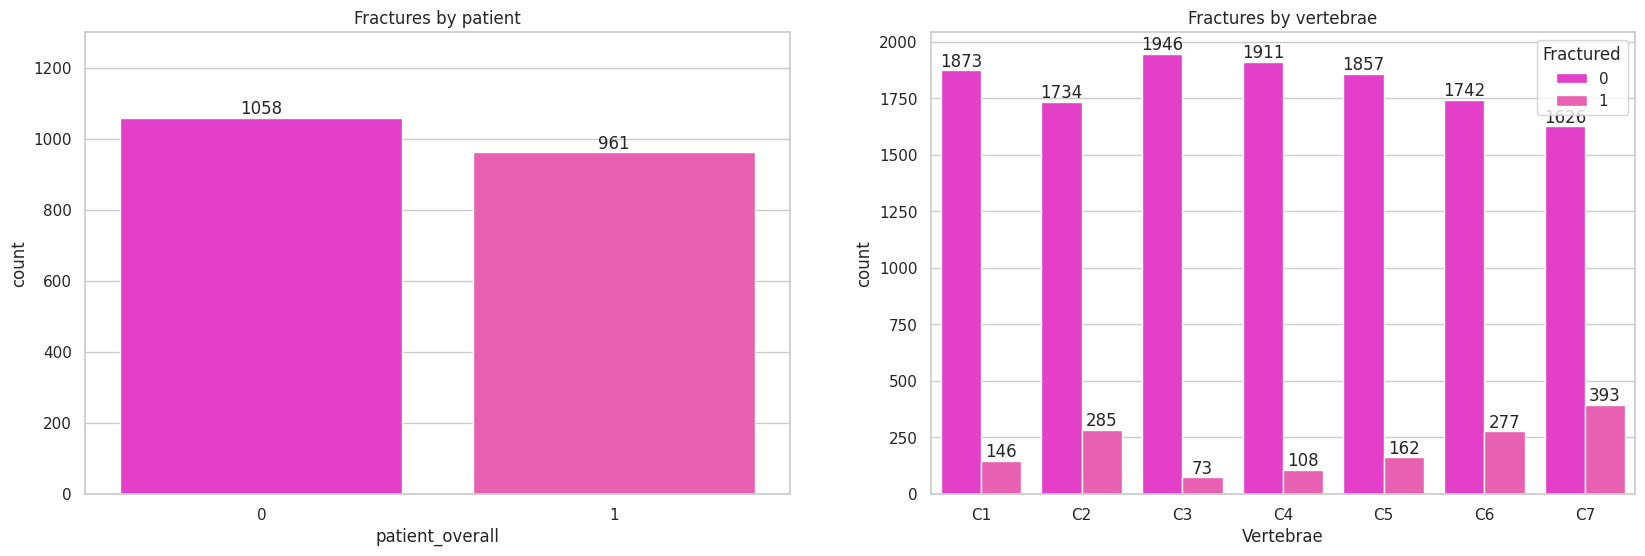

In [264]:
plt.figure(figsize=(20,6))
sns.set_palette('spring')
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_df, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures by patient')
plt.ylim([0,1300])


train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],value_vars = ['C1','C2','C3','C4','C5','C6','C7'],var_name="Vertebrae",value_name="Fractured")
plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vertebrae', hue='Fractured')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures by vertebrae')


Text(0.5, 0, 'Number of fractures')

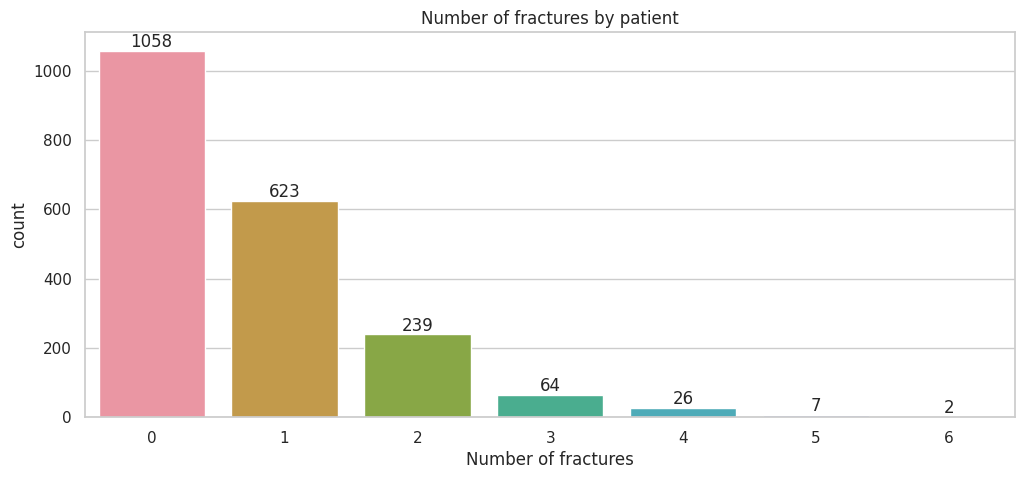

In [265]:
plt.figure(figsize=(12,5))

ax = sns.countplot(x = train_df[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of fractures by patient')
plt.xlabel('Number of fractures')


<AxesSubplot: >

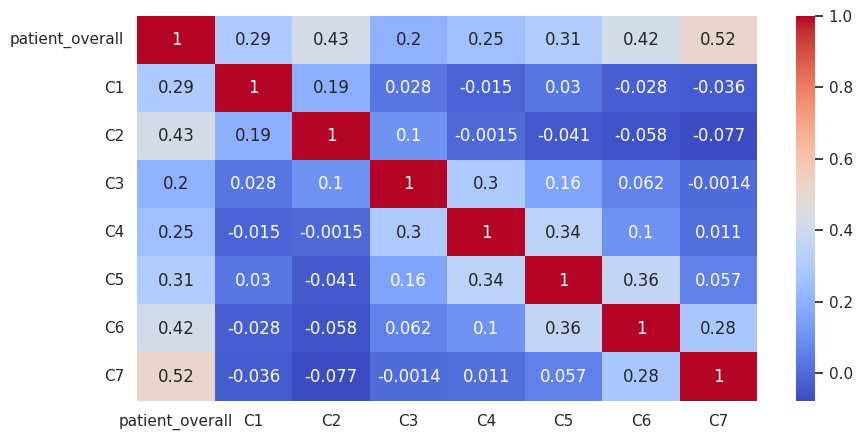

In [266]:
plt.figure(figsize=(10,5))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')

In [267]:
#The cases in the dataset have unique id's like '1.2.826.0.1.3680043.6200'. It turns out only the number after the last full stop is important.
# Find unique numbers in study id's.
for i in range(7):
    print(train_df['StudyInstanceUID'].map(lambda x : x.split('.')[i]).unique(), "\n")

['1'] 

['2'] 

['826'] 

['0'] 

['1'] 

['3680043'] 

['6200' '27262' '21561' ... '14341' '12053' '18786'] 



In [268]:
#handle .dcm files.
ex_path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001/101.dcm"
dcm_example = pydicom.dcmread(ex_path)
dcm_example

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10001.1.101
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10001.1.101
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '175846.512627'
(0010, 0010) Patient's Name                      PN: '10001'
(0010, 0020) Patient ID                          LO: '10001'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

In [269]:
sns.set(style='darkgrid', font_scale=1.6)

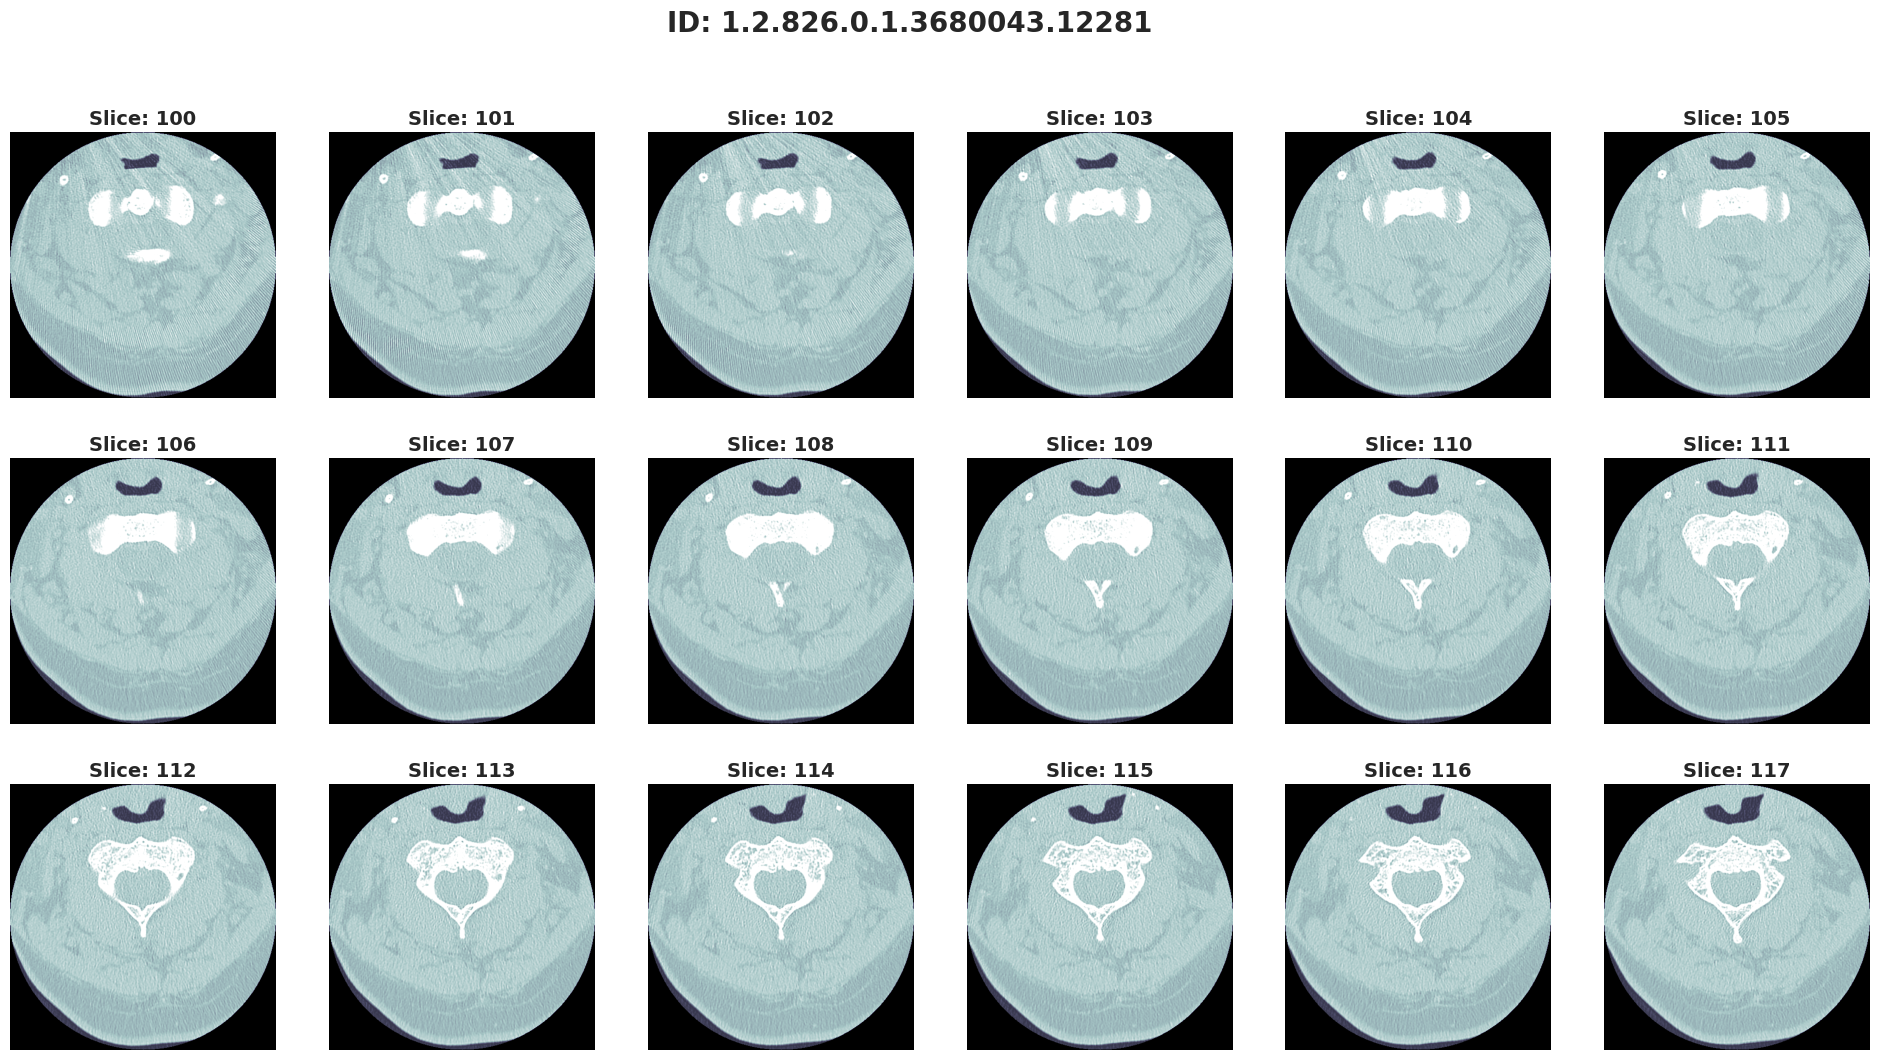

In [270]:
#show train images with random unique id
base_path = "../input/rsna-2022-cervical-spine-fracture-detection"
patient_id = '1.2.826.0.1.3680043.12281'
dcm_paths = glob(f"{base_path}/train_images/{patient_id}/*")
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]
dcm_paths.sort(key=natural_keys)

# Get images
files = [pydicom.dcmread(path) for path in dcm_paths]
images = [apply_voi_lut(file.pixel_array, file) for file in files]

# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

start = 100
for i in range(start,start+18):
    img = images[i]
    file = files[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

In [271]:
ex_path2 = f"../input/rsna-2022-cervical-spine-fracture-detection/segmentations/{patient_id}.nii"
nii_example = nib.load(ex_path2)

#convert to numpy array
seg = nii_example.get_fdata()
seg.shape

(512, 512, 331)

In [272]:
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
seg.shape

(331, 512, 512)

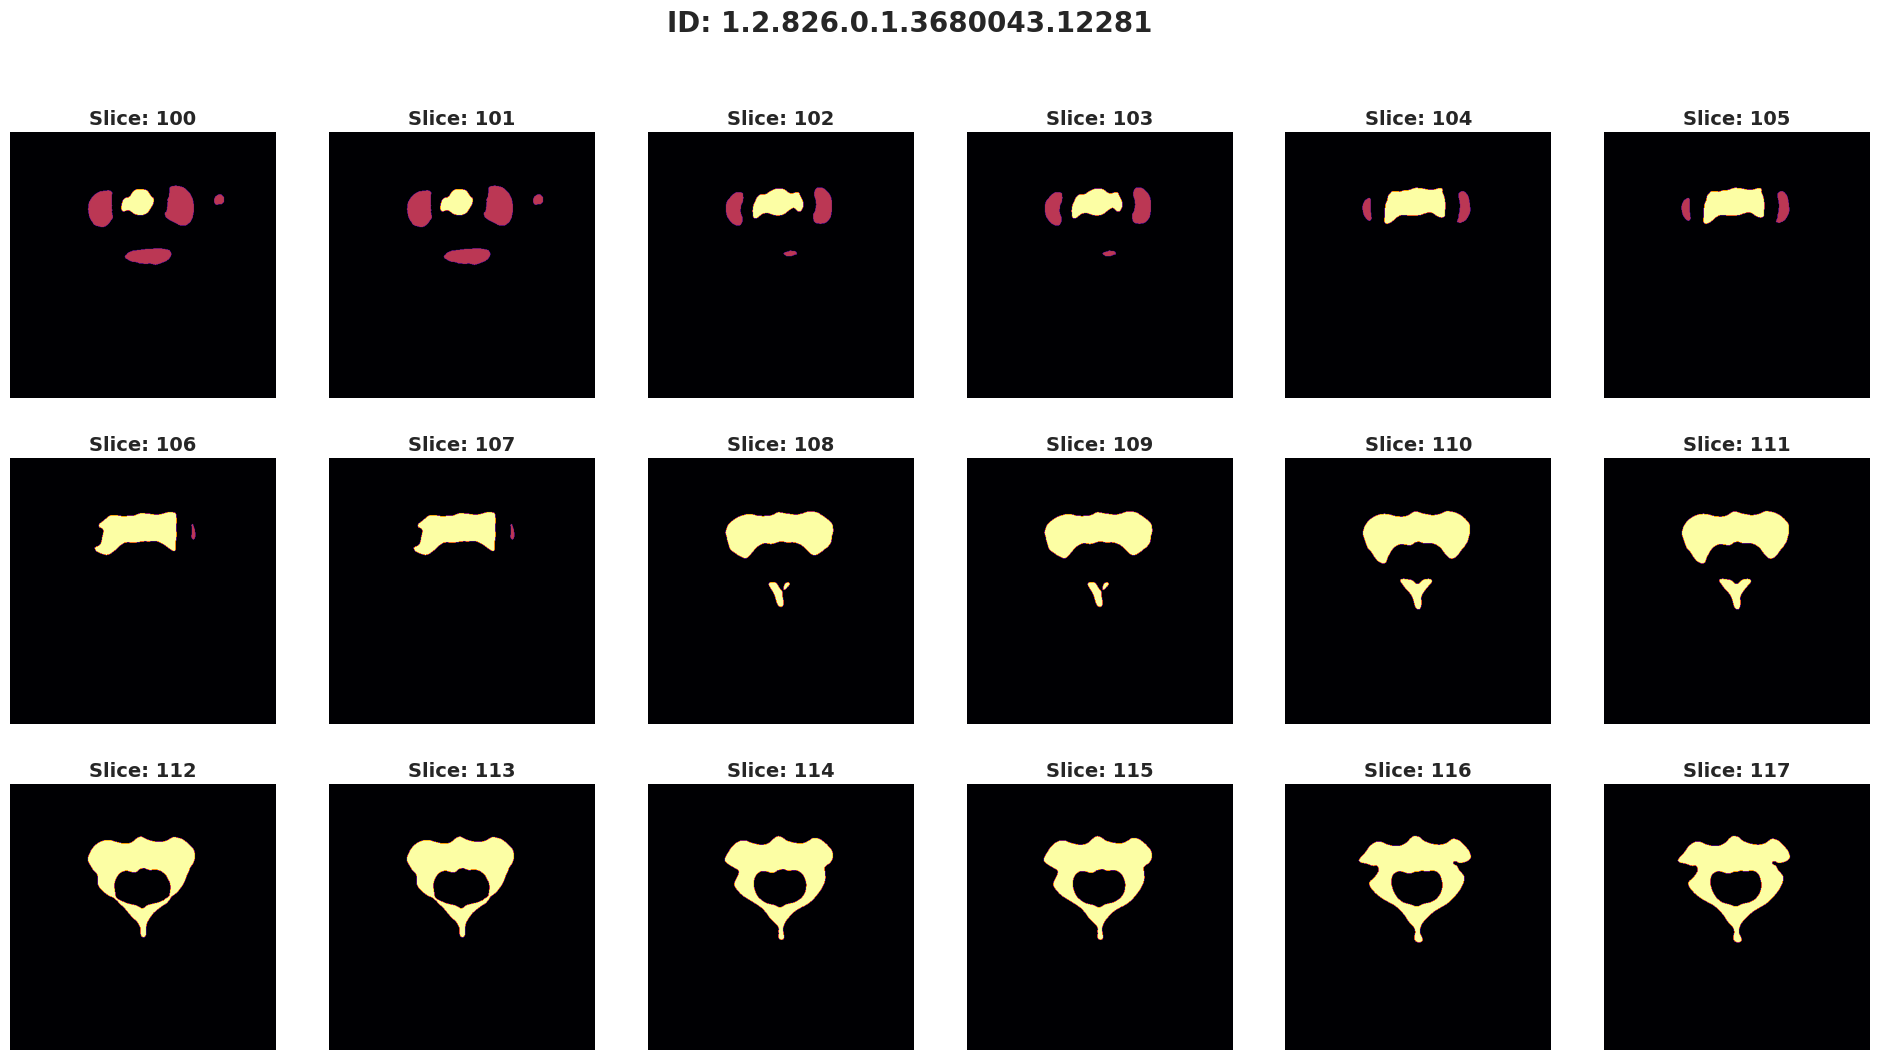

In [273]:
# show segmentation images (masks)
#plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

for i in range(start,start+18):
    mask = seg[i]
    slice_no = i

    #plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(mask, cmap='inferno')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

In [274]:
#show cervical fractures (labels) in segmentations
np.unique(seg[101])

array([0., 1., 2.])

In [275]:
#number of cases with masks
seg_paths = glob(f"{base_path}/segmentations/*")
print(f'Number of cases with segmentations: {len(seg_paths)}, ({np.round(100*len(seg_paths)/len(train_df),1)}%)')

Number of cases with segmentations: 87, (4.3%)


In [276]:
print(f'Patients with bounding box measurements: {train_bbox["StudyInstanceUID"].nunique()} ({np.round(100*train_bbox["StudyInstanceUID"].nunique()/len(train_df),1)} %)')

Patients with bounding box measurements: 235 (11.6 %)


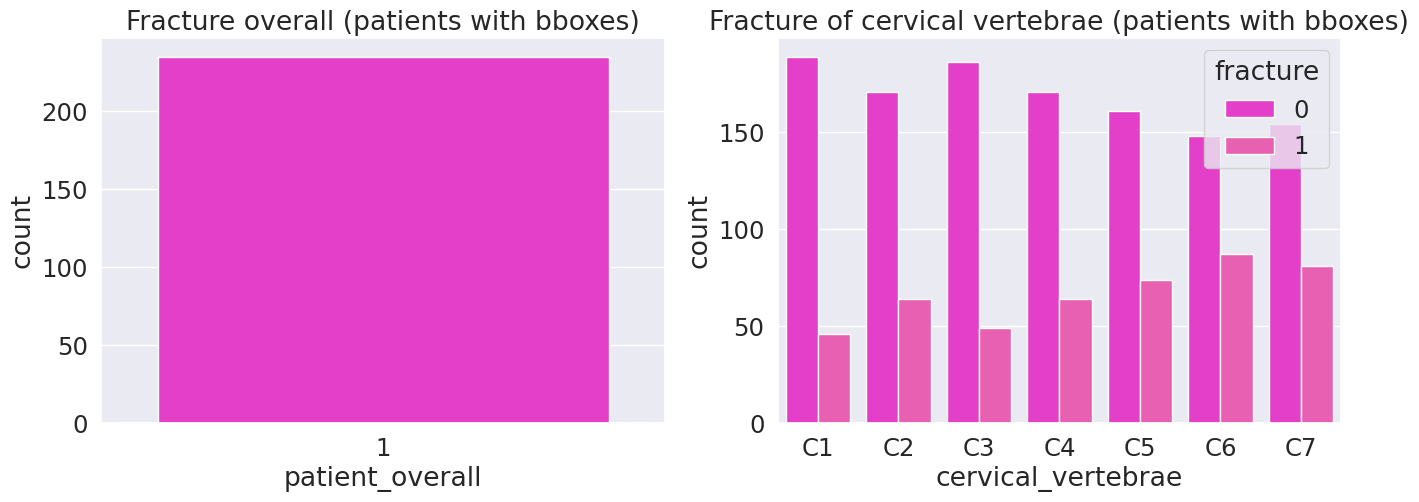

In [277]:
train_df_bbox = train_df[train_df["StudyInstanceUID"].isin(train_bbox["StudyInstanceUID"])]
sns.set_palette('spring')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x="patient_overall", data=train_df_bbox, ax=ax1)
ax1.set_title("Fracture overall (patients with bboxes)")
train_df_bbox_melt = pd.melt(train_df_bbox, id_vars=["StudyInstanceUID", "patient_overall"], var_name="cervical_vertebrae", value_name="fracture")
sns.countplot(x="cervical_vertebrae", hue="fracture", data=train_df_bbox_melt, ax=ax2)
ax2.set_title("Fracture of cervical vertebrae (patients with bboxes)")
plt.show()

Text(0.5, 0, 'Number of bboxes')

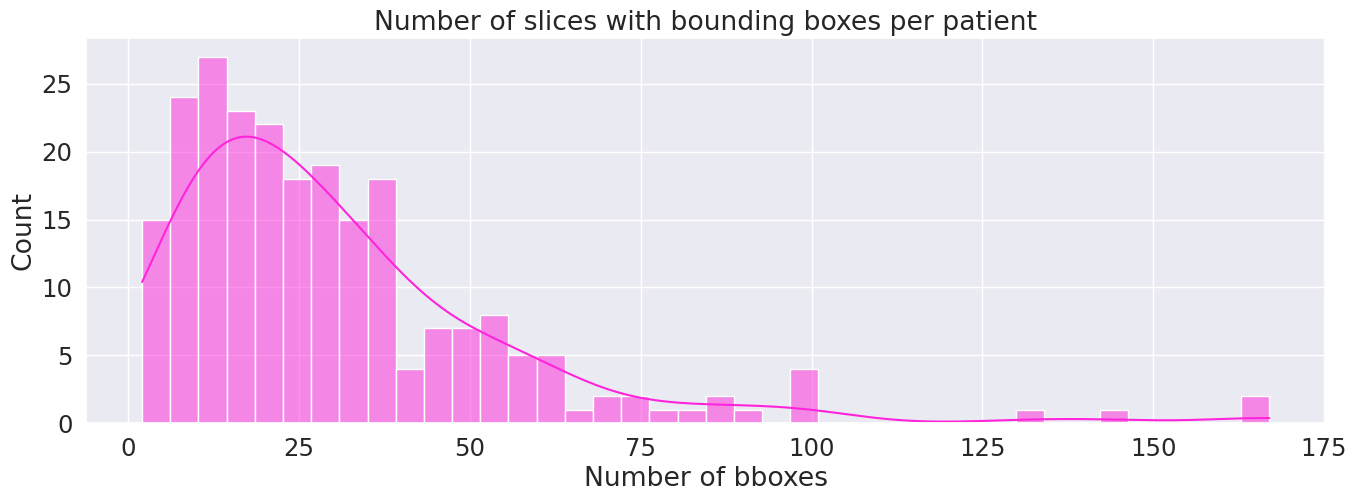

In [278]:
plt.figure(figsize=(16,5))
sns.histplot(train_bbox["StudyInstanceUID"].value_counts().values, kde=True, bins=40)
plt.title('Number of slices with bounding boxes per patient')
plt.xlabel('Number of bboxes')

Text(0.5, 1.0, 'Width and heights')

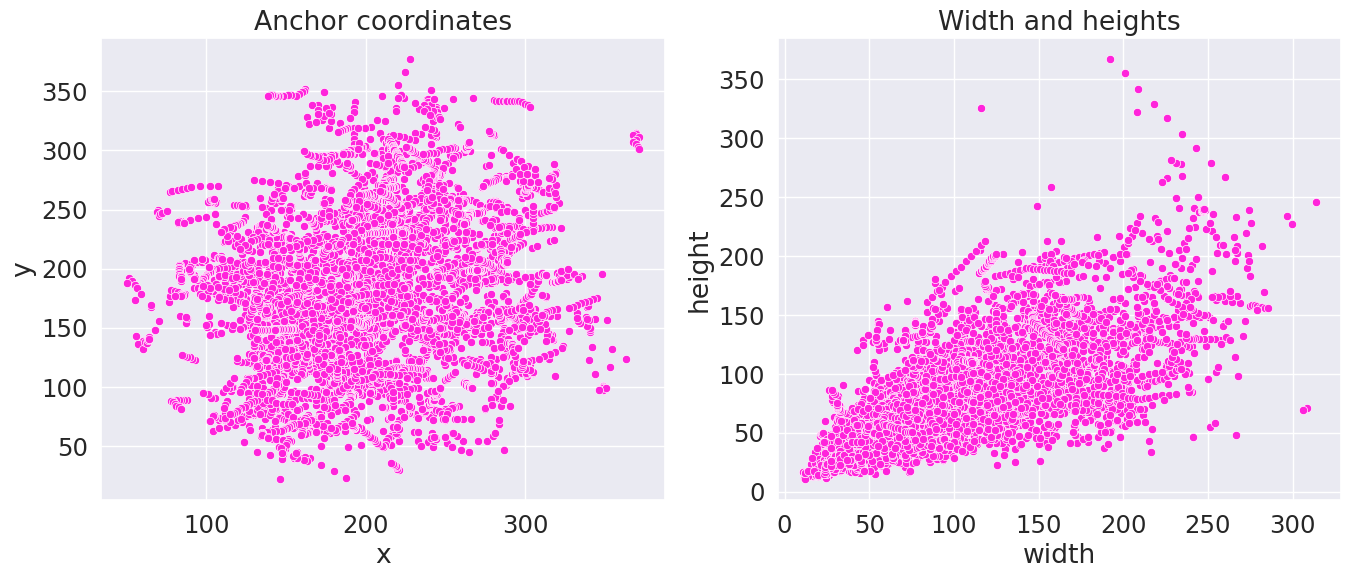

In [279]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.scatterplot(data=train_bbox, x='x', y='y')
plt.title('Anchor coordinates')

plt.subplot(1,2,2)
sns.scatterplot(data=train_bbox, x='width', y='height')
plt.title('Width and heights')

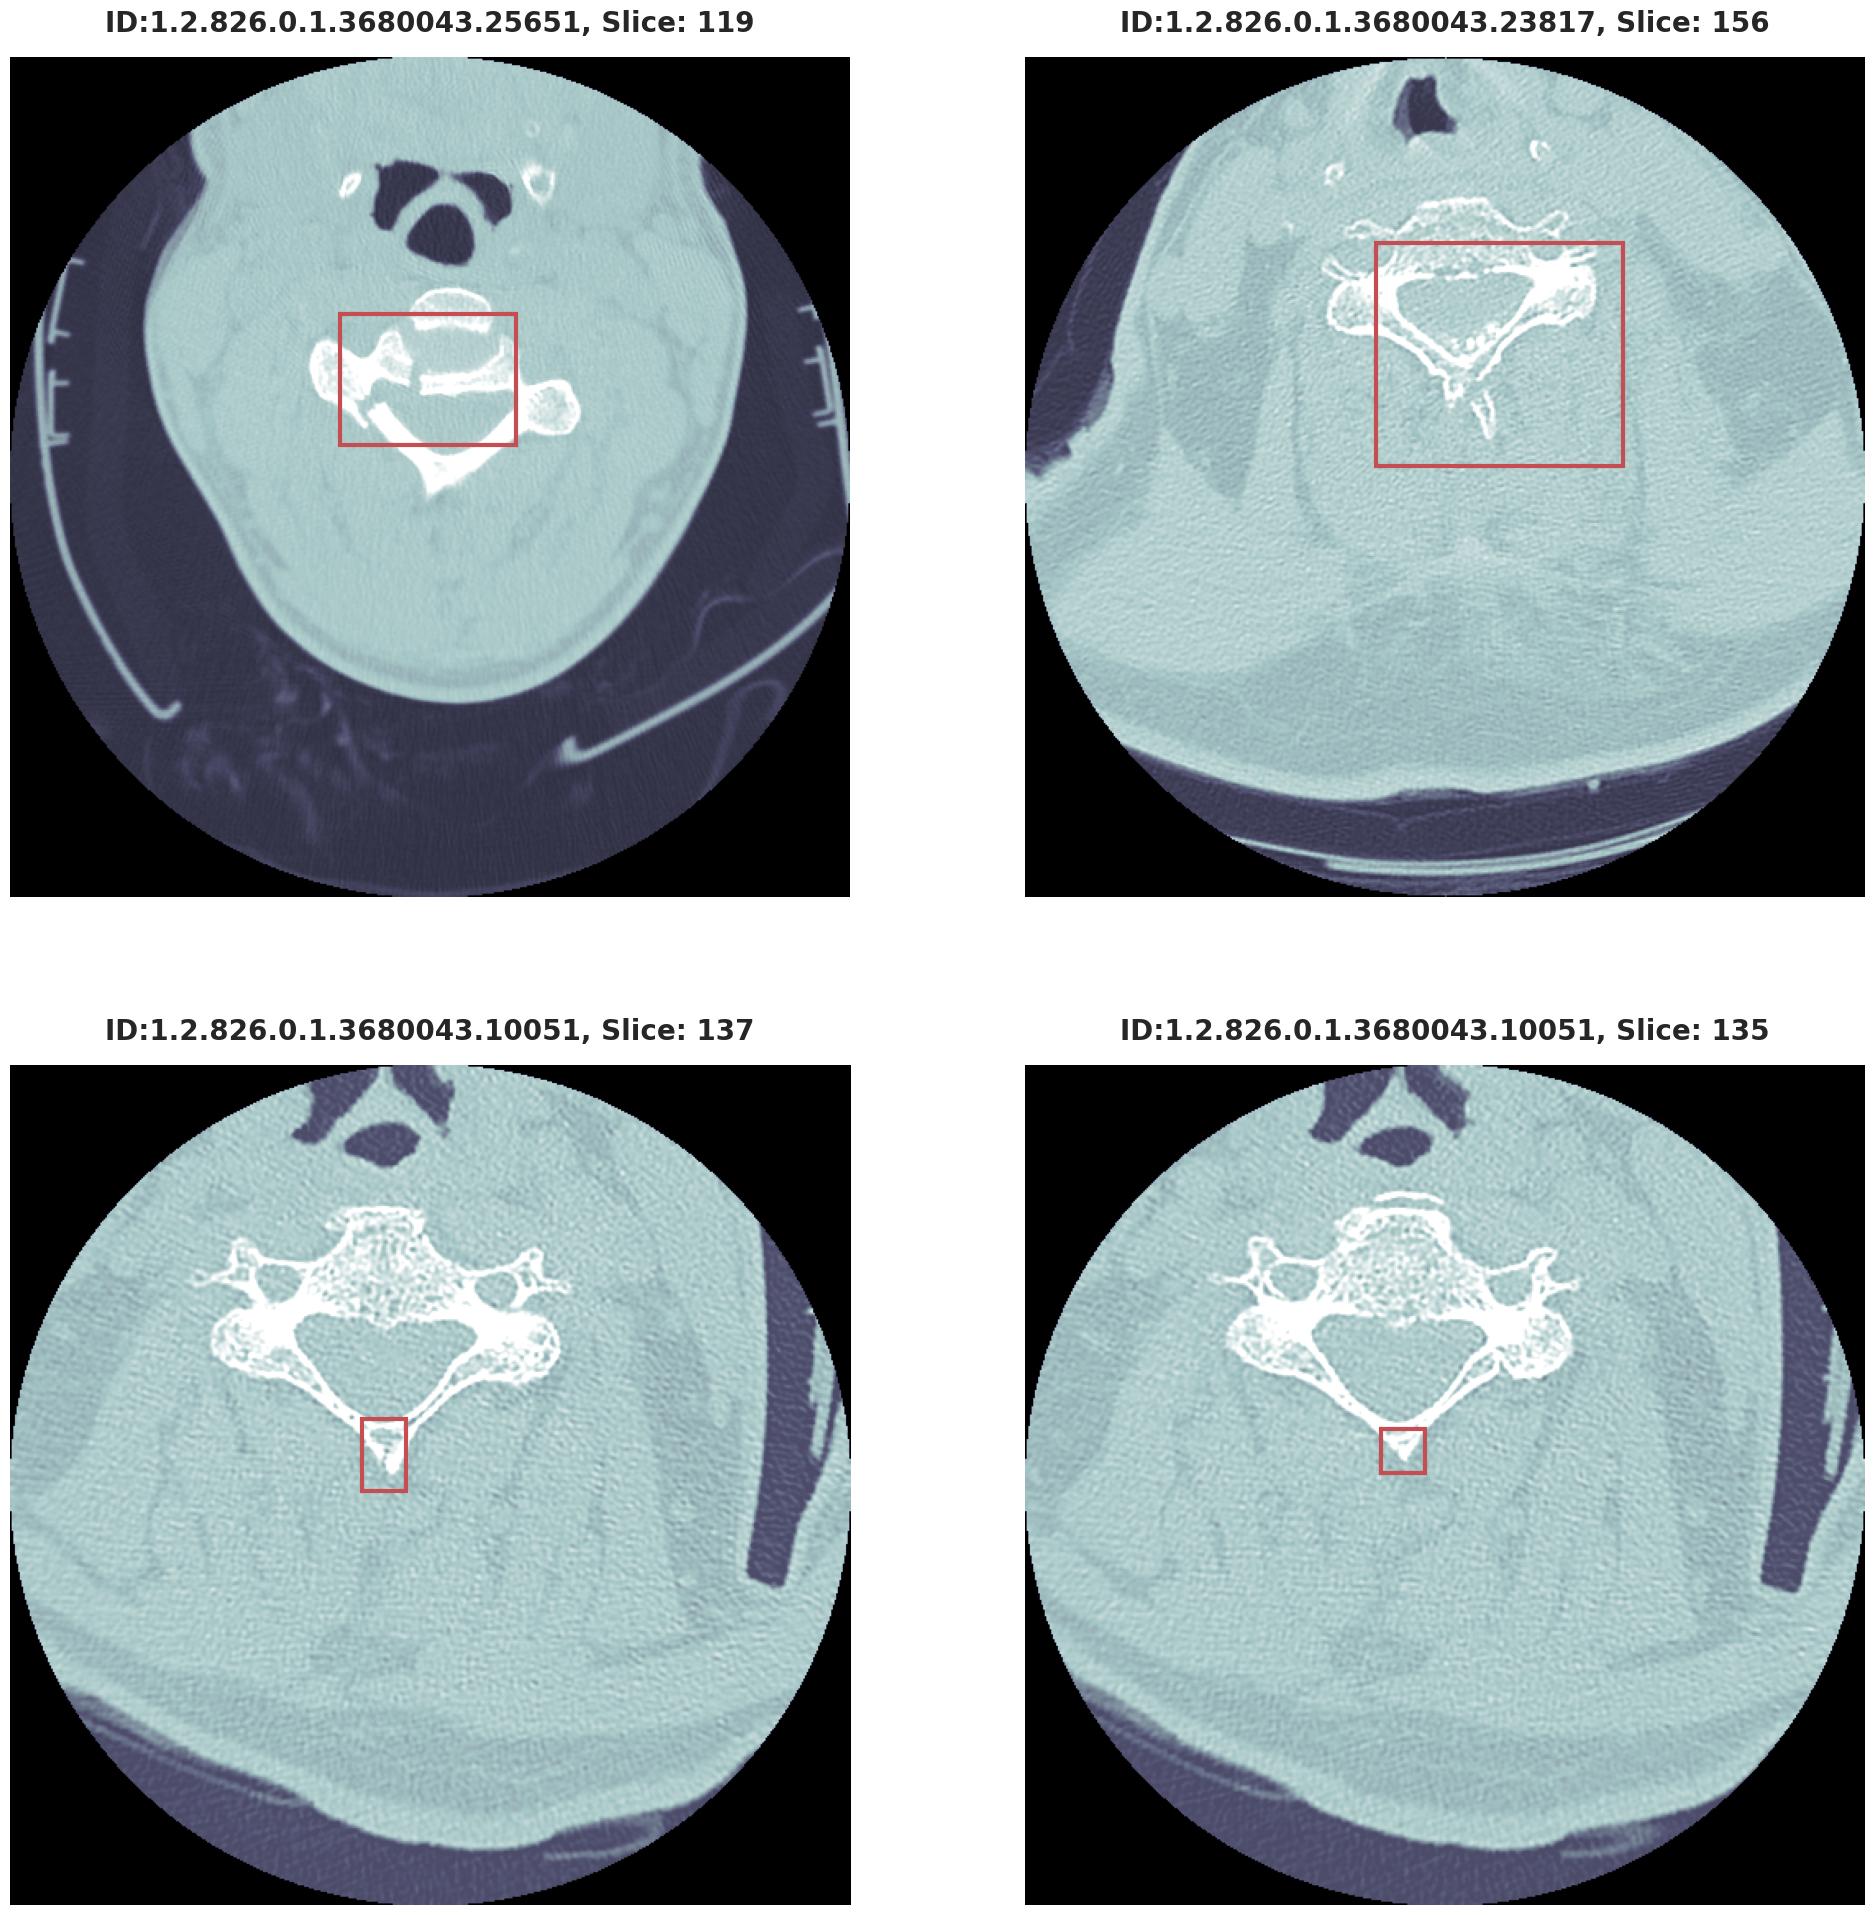

In [280]:
def plot_fracture(slice_num,bbox_id,ax_id1,ax_id2):
    file = pydicom.dcmread(f"{base_path}/train_images/{bbox_id}/{slice_num}.dcm")
    img = apply_voi_lut(file.pixel_array, file)
    info = train_bbox[(train_bbox['StudyInstanceUID']==bbox_id)&(train_bbox['slice_number']==slice_num)]
    rect = patches.Rectangle((float(info.x), float(info.y)), float(info.width), float(info.height), linewidth=3, edgecolor='r', facecolor='none')

    axes[ax_id1,ax_id2].imshow(img, cmap="bone")
    axes[ax_id1,ax_id2].add_patch(rect)
    axes[ax_id1,ax_id2].set_title(f"ID:{bbox_id}, Slice: {slice_num}", fontsize=20, weight='bold',y=1.02)
    axes[ax_id1,ax_id2].axis('off')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,24))
plot_fracture(119,'1.2.826.0.1.3680043.25651',0,0)
plot_fracture(156,'1.2.826.0.1.3680043.23817',0,1)
plot_fracture(137,'1.2.826.0.1.3680043.10051',1,0)
plot_fracture(135,'1.2.826.0.1.3680043.10051',1,1)

In [281]:
# dataset which is contains only masks and train images that is generated from main dataset 
datadir = '/kaggle/input/cervical-spine-segmentation/dataset'
mask_dir = os.path.join(datadir, 'masks')
image_dir = os.path.join(datadir, 'images')

In [282]:
images = [os.path.join(image_dir, i) for i in tqdm(os.listdir(image_dir))]
masks = [os.path.join(mask_dir, i) for i in tqdm(os.listdir(mask_dir))]

100%|██████████| 6005/6005 [00:00<00:00, 360181.84it/s]


In [283]:
def show_spine(n):
    mask = np.load(masks[n])
    image = np.load(images[n])
    
    classes = np.unique(mask)
    col = len(classes)+1
    figure, axis = plt.subplots(1, col, figsize=(16, 4))
    
    if col>1:
        axis[0].imshow(image, cmap="bone_r")
        axis[0].set_title('Image')
        axis[0].axis('off')

        for i,j in enumerate(classes):
            if i!=0:
                axis[i].imshow(mask==j, cmap="bone")
                axis[i].set_title(f'Cervical Spine : C{i}')
                axis[i].axis('off')

        axis[col-1].imshow(mask, cmap="bone")
        axis[col-1].set_title('Overall')
        axis[col-1].axis('off')

    else:
        plt.imshow(image)
    
    plt.show()

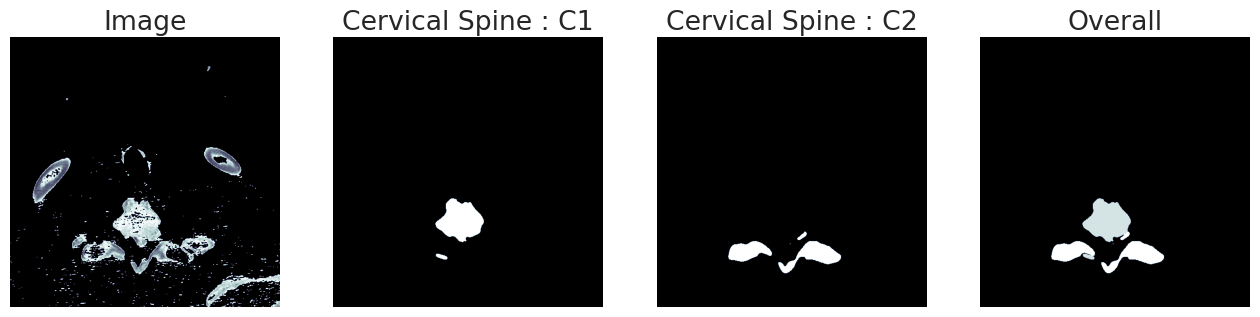

In [284]:
show_spine(10)

In [285]:
def crop_seg(n):
    mask = np.load(masks[n])
    image = np.load(images[n])

    classes = np.unique(mask)
    col = len(classes)+1
    if col>2:
        
        figure, axis = plt.subplots(1, col, figsize=(16, 4))

        axis[0].imshow(image, cmap="bone_r")
        axis[0].set_title('Image')
        axis[0].axis('off')

        for i,j in enumerate(classes):
            if i!=0:
                axis[i].imshow(image*(mask==j), cmap="bone")
                axis[i].set_title(f'Cervical Spine : C{j}')
                axis[i].axis('off')

        axis[col-1].imshow(image*mask, cmap="bone")
        axis[col-1].set_title(f'Cervical Spine')
        axis[col-1].axis('off')

    else:
        plt.imshow(image, cmap="bone_r")
        plt.title(f'Image --> No Cervical Spine Detected')
        plt.axis('off')

    plt.show()

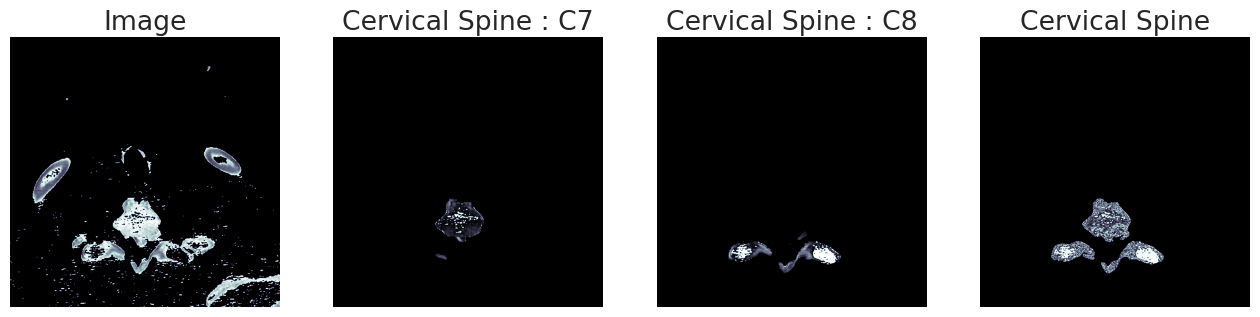

In [286]:
crop_seg(10)

In [287]:
dataset = []

In [288]:
np.unique(np.load(masks[10]))

array([0, 7, 8], dtype=uint8)

In [289]:
def save_crop_seg(n):
    mask = np.load(masks[n])
    image = np.load(images[n])
    
    name = masks[n].split('/')[-1]
    path = os.path.join('/kaggle/working/data/images', name)
    classes = np.unique(mask)
    
    for i,j in enumerate(classes):
        if i!=0:
            if (j>=1 and j<=7):
                np.save(f'{path}-C{j}', image*(mask==j))

In [290]:
!mkdir -p /kaggle/working/data
!rm /kaggle/working/data/*

!mkdir -p /kaggle/working/data/images
!rm /kaggle/working/data/images/*

rm: cannot remove '/kaggle/working/data/images': Is a directory


In [291]:
#try saving one cropped mask
save_crop_seg(10)

In [292]:
#save all cropped masks
for i in tqdm(range(len(masks))):
    save_crop_seg(i)

100%|██████████| 6005/6005 [00:36<00:00, 162.73it/s]


In [298]:
plt.style.use("Solarize_Light2")

In [299]:
datadir = '/kaggle/working/data/images'

In [300]:
data = [[i, i.split('-')[1].split('.')[0]] for i in os.listdir(datadir)]

In [301]:
data = pd.DataFrame(data, columns=['path', 'class'])
data.head()

path class
0  1.2.826.0.1.3680043.32436_174.npy-C7.npy    C7
1  1.2.826.0.1.3680043.26068_284.npy-C5.npy    C5
2  1.2.826.0.1.3680043.32280_205.npy-C7.npy    C7
3  1.2.826.0.1.3680043.30640_148.npy-C6.npy    C6
4   1.2.826.0.1.3680043.30524_54.npy-C1.npy    C1

In [302]:
import warnings
warnings.simplefilter(action='ignore')
tqdm.pandas()

In [303]:
data['StudyInstanceUID'] = data.path.progress_apply(lambda x: x.split('-')[0].split('_')[0])

100%|██████████| 6319/6319 [00:00<00:00, 371118.61it/s]


In [304]:
train =pd.read_csv('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train.csv')
train.head()

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0
3  1.2.826.0.1.3680043.12351                0   0   0   0   0   0   0   0
4   1.2.826.0.1.3680043.1363                1   0   0   0   0   1   0   0

In [305]:
final_data = pd.merge(train, data, on='StudyInstanceUID', how='inner')
final_data.head()


StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7  \
0  1.2.826.0.1.3680043.20647                0   0   0   0   0   0   0   0   
1  1.2.826.0.1.3680043.20647                0   0   0   0   0   0   0   0   
2  1.2.826.0.1.3680043.20647                0   0   0   0   0   0   0   0   
3  1.2.826.0.1.3680043.20647                0   0   0   0   0   0   0   0   
4  1.2.826.0.1.3680043.20647                0   0   0   0   0   0   0   0   

                                       path class  
0   1.2.826.0.1.3680043.20647_73.npy-C2.npy    C2  
1  1.2.826.0.1.3680043.20647_116.npy-C4.npy    C4  
2  1.2.826.0.1.3680043.20647_181.npy-C6.npy    C6  
3   1.2.826.0.1.3680043.20647_76.npy-C2.npy    C2  
4  1.2.826.0.1.3680043.20647_114.npy-C4.npy    C4

In [306]:
def get_df_by_cat(category):
    cat = final_data[final_data['class']==category]
    cat = cat[['path', category]]
    cat.rename(columns = { category : 'Output'}, inplace = True)

    return cat

In [307]:
final_C1 = get_df_by_cat('C1')
final_C2 = get_df_by_cat('C2')
final_C3 = get_df_by_cat('C3')
final_C4 = get_df_by_cat('C4')
final_C5 = get_df_by_cat('C5')
final_C6 = get_df_by_cat('C6')
final_C7 = get_df_by_cat('C7')

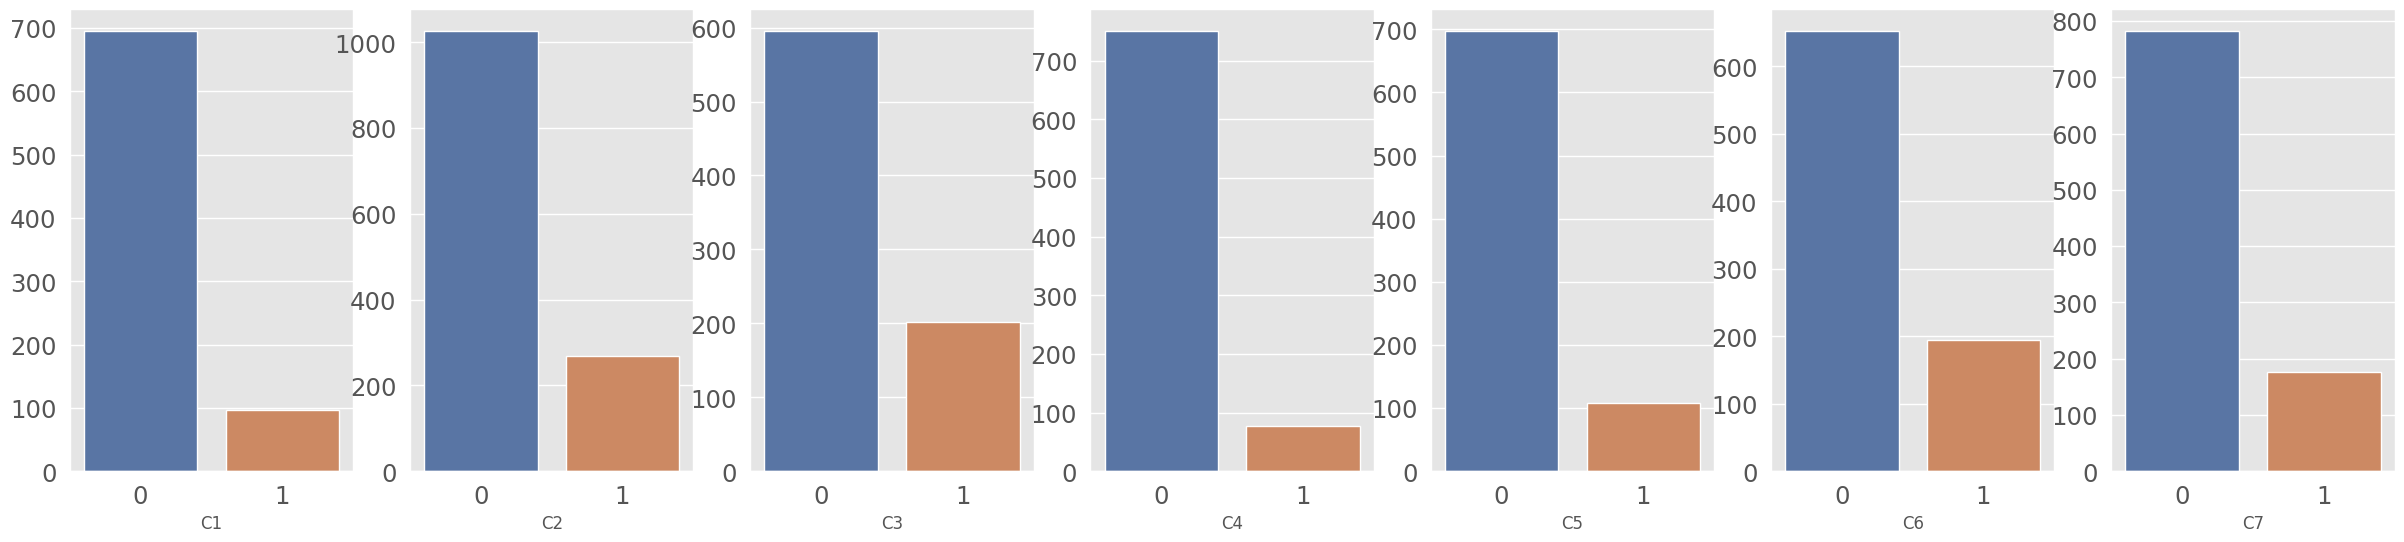

In [310]:
f, axes = plt.subplots(1, 7, figsize=(30, 6))
sns.set(style='whitegrid')
for i, j in enumerate([final_C1, final_C2, final_C3, final_C4, final_C5, final_C6, final_C7]):
    ax = sns.countplot(j, x='Output', ax=axes[i])
    ax.set(xlabel=f'C{i+1}')
    ax.set(ylabel=None)

plt.show()

In [313]:
def plot_confusion_matrix(y_test, y_pred, color="Oranges"):
    plt.figure(figsize=(3,3))
    labels = np.unique(y_pred)
    cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
    sns.heatmap(cm_df, annot=True, fmt='g', cmap=color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

    
def build_model(data, tl_name='resnet', batch_size=16):
    # Split data into train and test set
    train, test = train_test_split(
        data,
        test_size=0.33, 
        shuffle=True
    )
    
    # Loading train images as numpy array from path
    train_images = train['path'].progress_apply(lambda x: np.load(f'{datadir}/{x}')).to_numpy()
    train_images = np.stack(train_images)
    train_images = np.reshape(train_images,(-1,512,512,1))
    
    # Loading Test Images as numpy array from path
    test_images = test['path'].progress_apply(lambda x: np.load(f'{datadir}/{x}')).to_numpy()
    test_images = np.stack(test_images)
    test_images = np.reshape(test_images,(-1,512,512,1))
    
    # Loading labels
    train_labels = train.Output.to_numpy()
    test_labels = test.Output.to_numpy()
    
    cat = data.path.to_numpy()[0].split('-')[1].split('.')[0]
    model_name = f'spine_{cat}.h5'
        
    print(f"""***************************** Category : {cat}, Output file name: {model_name} ***************************************""")

    # Define EarlyStopping
    early_stopping = callbacks.EarlyStopping(
        monitor='accuracy',
        min_delta=0.001, # minimium amount of change to count as an improvement
        patience=3, # how many epochs to wait before stopping
        restore_best_weights=True,
    )

    if tl_name=='resnet':
        # Load Resnet50 neural network
        base_model = ResNet50(weights=None, include_top=False, input_shape=(512, 512, 1))
        
        # Fit base_model into model
        model = tf.keras.models.Sequential()
        model.add(base_model)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(256, activation='relu'))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        
        # Print Model Summary
        print(model.summary())
        
        # Compile the model
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'],)
        
        print("""**********************************************  Training Data... **************************************************""")

        history = model.fit(train_images, train_labels, batch_size=batch_size , epochs=50,use_multiprocessing=True,shuffle=True,callbacks=[early_stopping],validation_data=(test_images,test_labels))
        
        print("""*******************************************  Dataset Trained Successfully  *****************************************""")
        
        predicted_labels = [1 if i>=0.5 else 0 for i in model.predict(np.array(test_images))]
        
        model.evaluate(test_images,test_labels)
        
        print("""***************************************** Training Loss vs Validation Loss ***************************************** """)
        history_df = pd.DataFrame(history.history)
        history_df.loc[:, ['loss', 'val_loss']].plot()
        plt.show()
        
        print("""************************************ Training Accuracy vs Validation Accuracy **************************************""")
        history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
        plt.show()
        print(""" ***************************************************** Result *******************************************************""")
        print("Classification Report:\n")        
        print(classification_report(test_labels, predicted_labels))
        
        print("""***************************************************** Plotting The Result ********************************************************""")
        pd.DataFrame(classification_report(test_labels, predicted_labels, output_dict=True)).transpose().head(2).drop(columns='support').plot.bar()
        plt.show()
        print(""" ************************************************* Confusion Matrix **************************************************""")

        # Plot Confusion Matrix
        plot_confusion_matrix(test_labels, predicted_labels)
        

100%|██████████| 262/262 [00:00<00:00, 389.59it/s]


***************************** Category : C1, Output file name: spine_C1.h5 ***************************************
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23581440  
                                                                 
 flatten_1 (Flatten)         (None, 524288)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               134217984 
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 157,799,681
Trainable params: 157,746,561
Non-trainable params: 53,120
_________________________________________________________________
None
********************************************** 

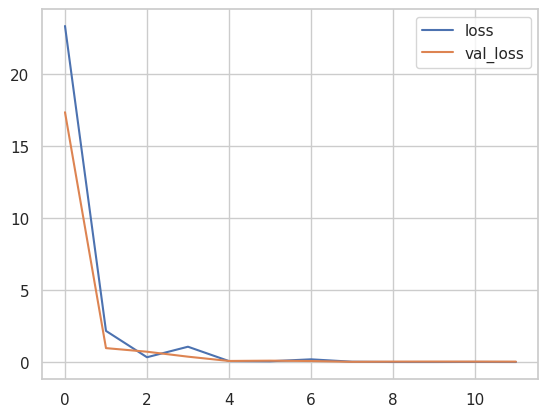

************************************ Training Accuracy vs Validation Accuracy **************************************


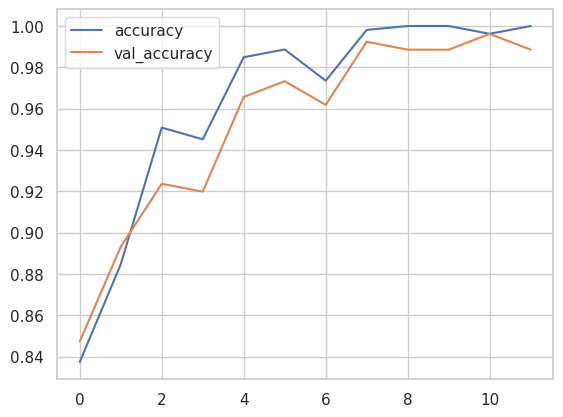

 ***************************************************** Result *******************************************************
Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       224
           1       1.00      0.92      0.96        38

    accuracy                           0.99       262
   macro avg       0.99      0.96      0.98       262
weighted avg       0.99      0.99      0.99       262

***************************************************** Plotting The Result ********************************************************


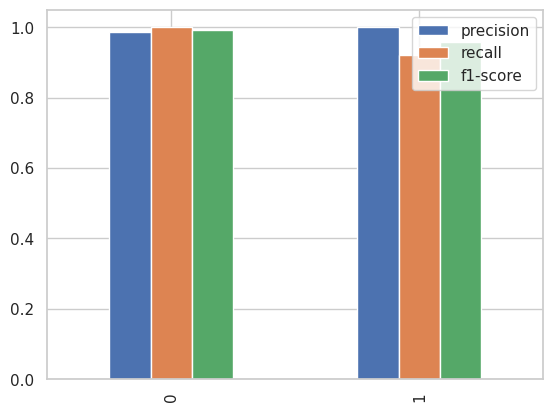

 ************************************************* Confusion Matrix **************************************************


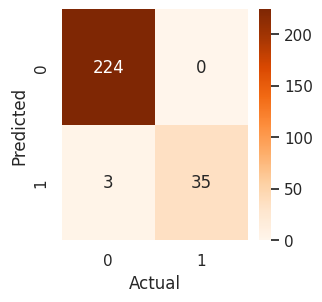

In [314]:
build_model(final_C1)

100%|██████████| 428/428 [00:01<00:00, 378.76it/s]


***************************** Category : C2, Output file name: spine_C2.h5 ***************************************
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23581440  
                                                                 
 flatten_2 (Flatten)         (None, 524288)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               134217984 
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 157,799,681
Trainable params: 157,746,561
Non-trainable params: 53,120
_________________________________________________________________
None
********************************************** 

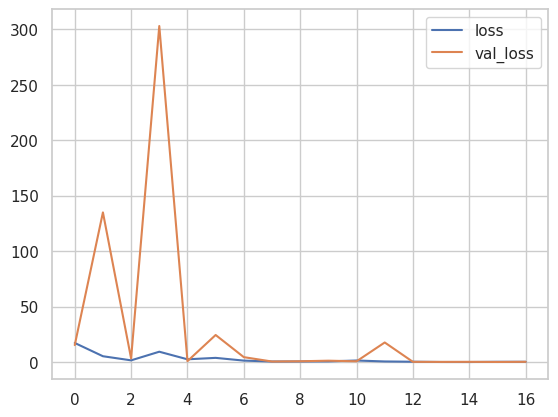

************************************ Training Accuracy vs Validation Accuracy **************************************


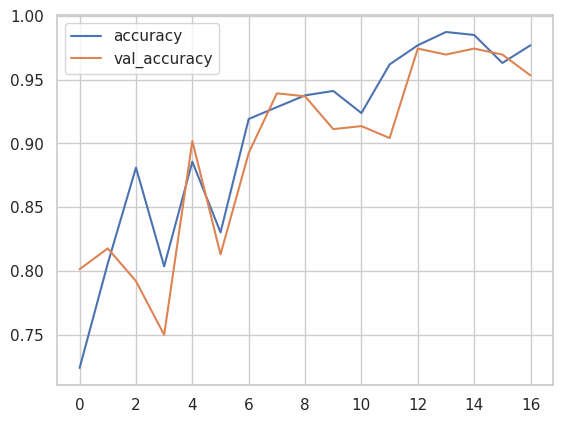

 ***************************************************** Result *******************************************************
Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       338
           1       0.95      0.90      0.93        90

    accuracy                           0.97       428
   macro avg       0.96      0.94      0.95       428
weighted avg       0.97      0.97      0.97       428

***************************************************** Plotting The Result ********************************************************


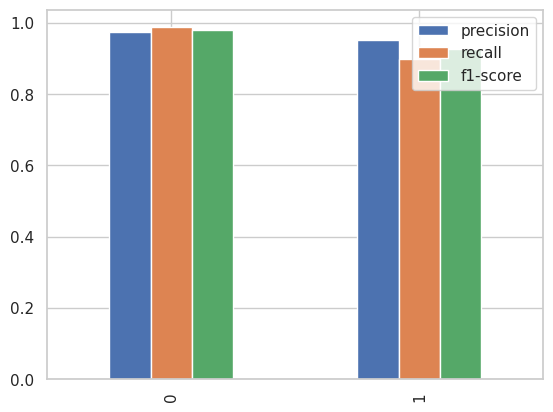

 ************************************************* Confusion Matrix **************************************************


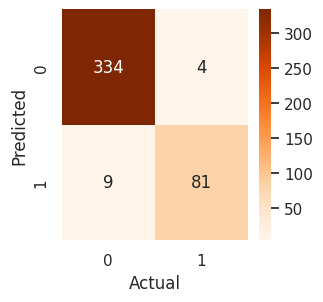

In [315]:
build_model(final_C2)

100%|██████████| 264/264 [00:00<00:00, 386.49it/s]


***************************** Category : C3, Output file name: spine_C3.h5 ***************************************
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23581440  
                                                                 
 flatten_3 (Flatten)         (None, 524288)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               134217984 
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 157,799,681
Trainable params: 157,746,561
Non-trainable params: 53,120
_________________________________________________________________
None
********************************************** 

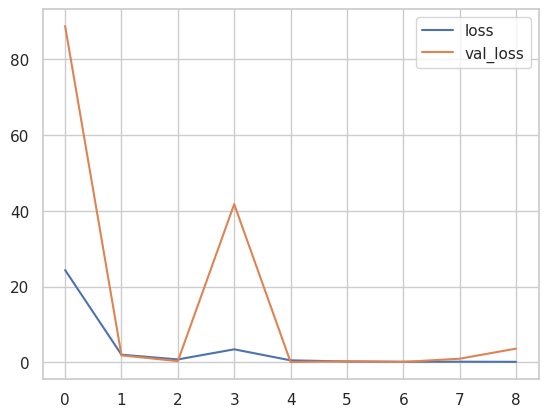

************************************ Training Accuracy vs Validation Accuracy **************************************


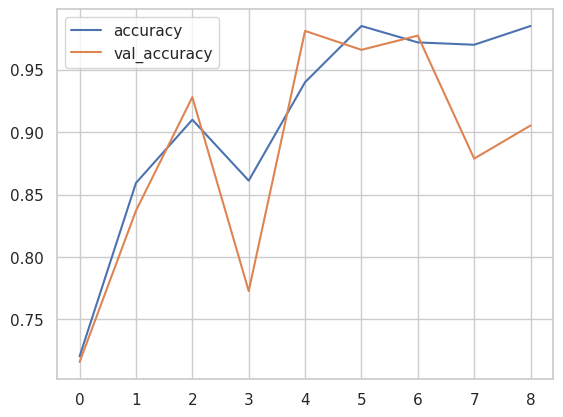

 ***************************************************** Result *******************************************************
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       184
           1       0.99      0.90      0.94        80

    accuracy                           0.97       264
   macro avg       0.97      0.95      0.96       264
weighted avg       0.97      0.97      0.97       264

***************************************************** Plotting The Result ********************************************************


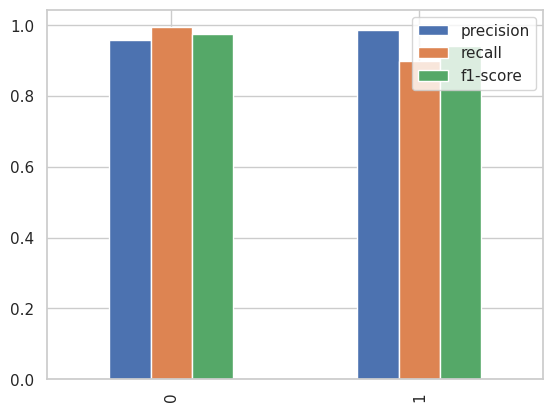

 ************************************************* Confusion Matrix **************************************************


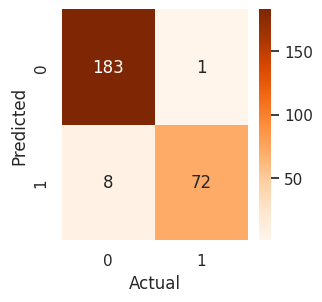

In [316]:
build_model(final_C3, batch_size=8)

100%|██████████| 273/273 [00:00<00:00, 368.35it/s]


***************************** Category : C4, Output file name: spine_C4.h5 ***************************************
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23581440  
                                                                 
 flatten_4 (Flatten)         (None, 524288)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               134217984 
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 157,799,681
Trainable params: 157,746,561
Non-trainable params: 53,120
_________________________________________________________________
None
********************************************** 

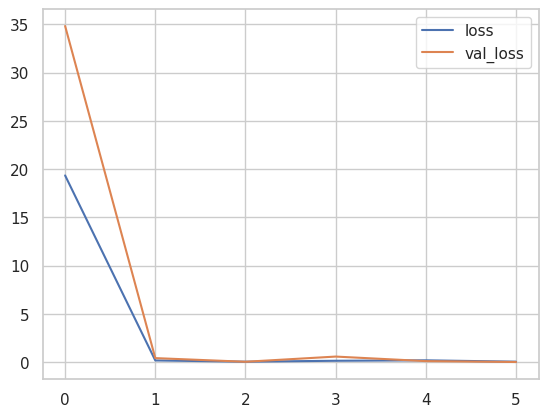

************************************ Training Accuracy vs Validation Accuracy **************************************


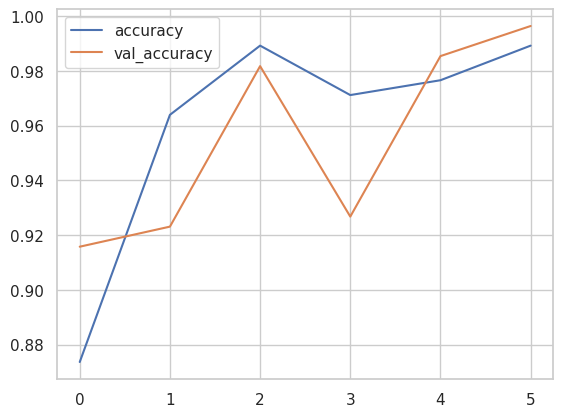

 ***************************************************** Result *******************************************************
Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       248
           1       1.00      0.80      0.89        25

    accuracy                           0.98       273
   macro avg       0.99      0.90      0.94       273
weighted avg       0.98      0.98      0.98       273

***************************************************** Plotting The Result ********************************************************


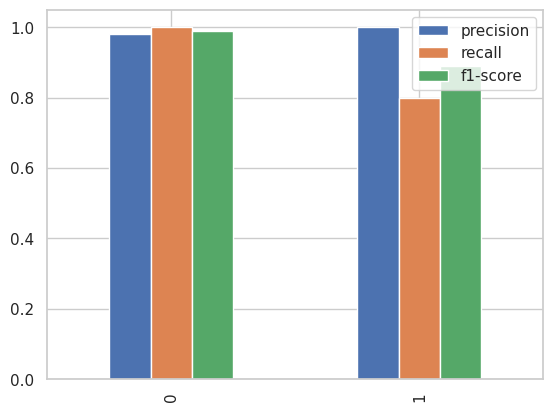

 ************************************************* Confusion Matrix **************************************************


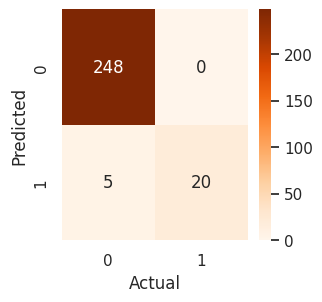

In [317]:
build_model(final_C4, batch_size=8)

100%|██████████| 266/266 [00:00<00:00, 410.36it/s]


***************************** Category : C5, Output file name: spine_C5.h5 ***************************************
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23581440  
                                                                 
 flatten_5 (Flatten)         (None, 524288)            0         
                                                                 
 dense_10 (Dense)            (None, 256)               134217984 
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 157,799,681
Trainable params: 157,746,561
Non-trainable params: 53,120
_________________________________________________________________
None
********************************************** 

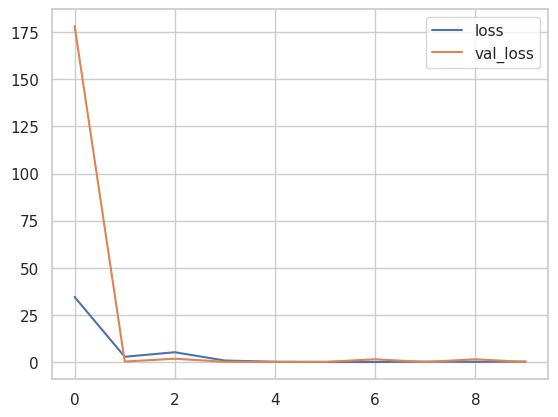

************************************ Training Accuracy vs Validation Accuracy **************************************


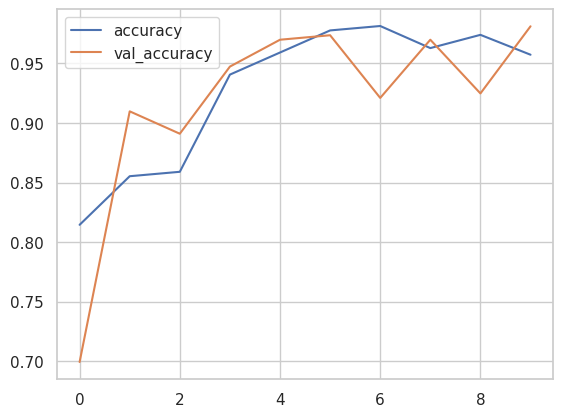

 ***************************************************** Result *******************************************************
Classification Report:

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       233
           1       0.93      0.39      0.55        33

    accuracy                           0.92       266
   macro avg       0.92      0.69      0.75       266
weighted avg       0.92      0.92      0.91       266

***************************************************** Plotting The Result ********************************************************


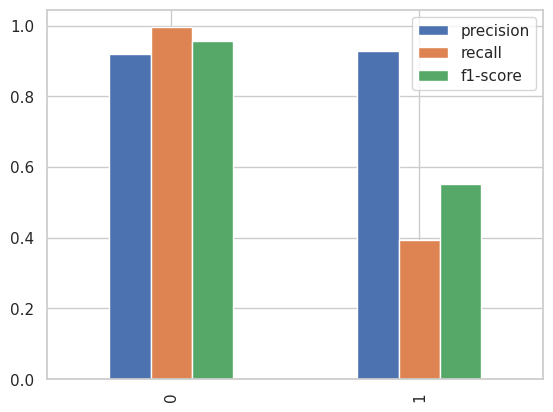

 ************************************************* Confusion Matrix **************************************************


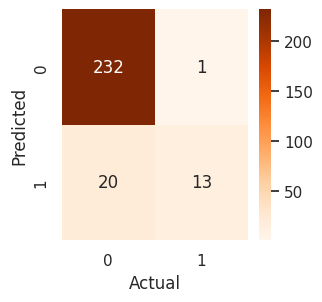

In [318]:
build_model(final_C5, batch_size=8)

100%|██████████| 280/280 [00:00<00:00, 399.55it/s]


***************************** Category : C6, Output file name: spine_C6.h5 ***************************************
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23581440  
                                                                 
 flatten_6 (Flatten)         (None, 524288)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               134217984 
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 157,799,681
Trainable params: 157,746,561
Non-trainable params: 53,120
_________________________________________________________________
None
********************************************** 

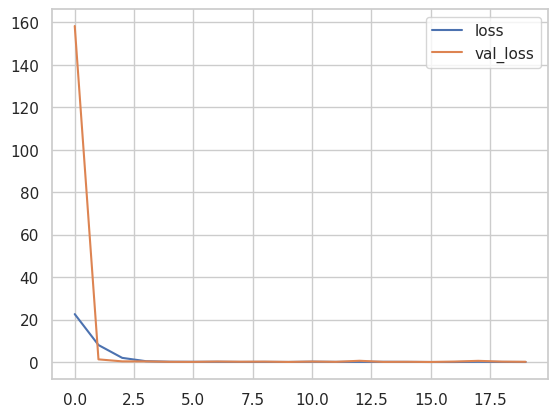

************************************ Training Accuracy vs Validation Accuracy **************************************


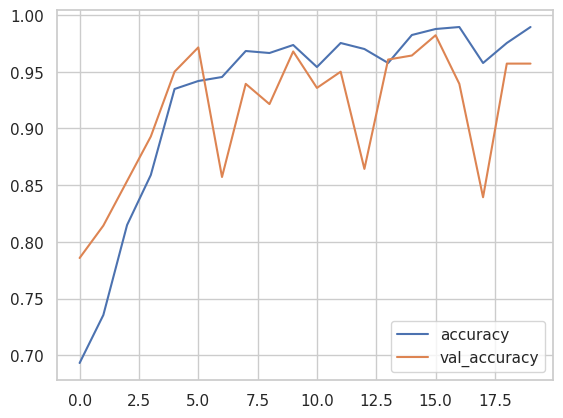

 ***************************************************** Result *******************************************************
Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       216
           1       0.94      0.78      0.85        64

    accuracy                           0.94       280
   macro avg       0.94      0.88      0.91       280
weighted avg       0.94      0.94      0.94       280

***************************************************** Plotting The Result ********************************************************


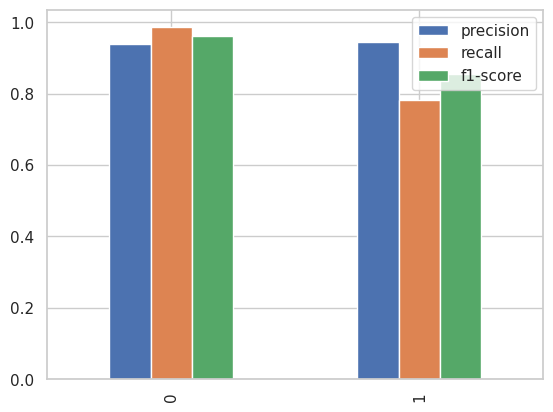

 ************************************************* Confusion Matrix **************************************************


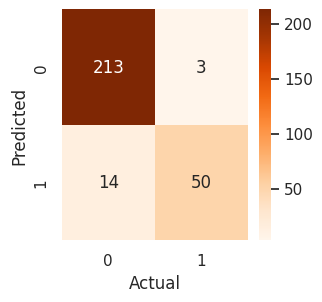

In [319]:
build_model(final_C6, batch_size=4)

100%|██████████| 317/317 [00:00<00:00, 394.67it/s]


***************************** Category : C7, Output file name: spine_C7.h5 ***************************************
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23581440  
                                                                 
 flatten_7 (Flatten)         (None, 524288)            0         
                                                                 
 dense_14 (Dense)            (None, 256)               134217984 
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 157,799,681
Trainable params: 157,746,561
Non-trainable params: 53,120
_________________________________________________________________
None
********************************************** 

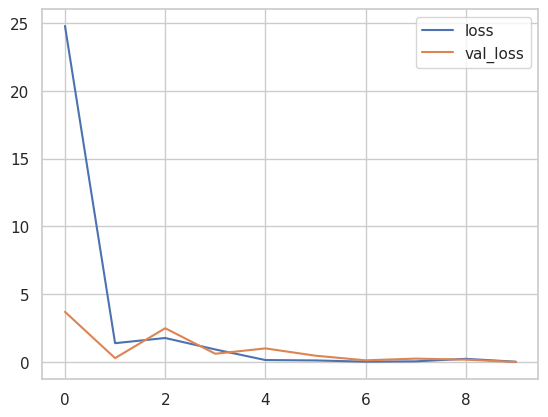

************************************ Training Accuracy vs Validation Accuracy **************************************


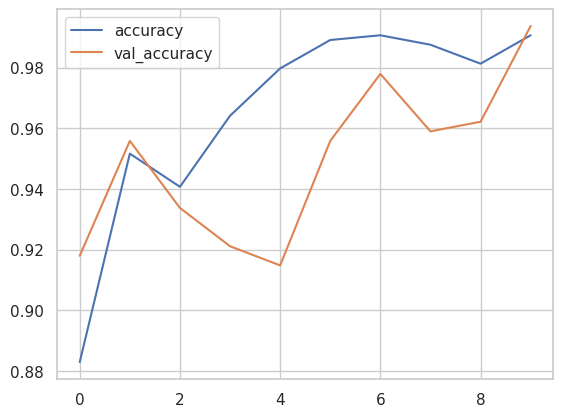

 ***************************************************** Result *******************************************************
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       246
           1       0.92      0.99      0.95        71

    accuracy                           0.98       317
   macro avg       0.96      0.98      0.97       317
weighted avg       0.98      0.98      0.98       317

***************************************************** Plotting The Result ********************************************************


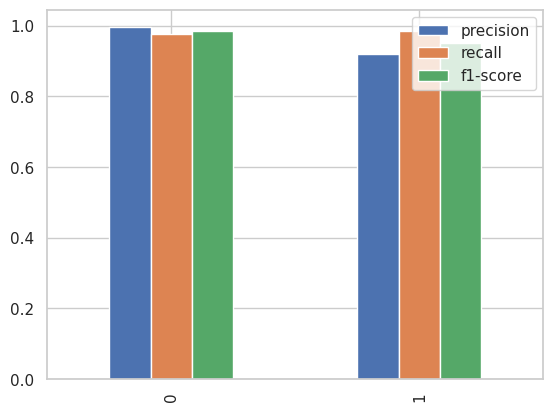

 ************************************************* Confusion Matrix **************************************************


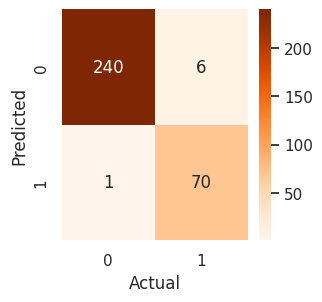

In [320]:
build_model(final_C7, batch_size=4)